In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import confusion_matrix, classification_report
import warnings
import statsmodels.api as sm
from scipy.stats import bartlett
from scipy.stats import levene
from IPython.display import display_html
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('SELECT * FROM houseprices', con = engine)

engine.dispose()

In [3]:
#Helpers teacher showed and are SUPER HELPFUL!
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)


def top_corrs(df, column, n=10):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(10)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()


def na_summary(df, group_col, additional_cols=None):
    if additional_cols is None:
        additional_cols = ["log_saleprice"]

    additional_cols.append(group_col)
    # fmt: off
    df = (
      df[additional_cols]
        .fillna("NaN")
        .groupby(group_col)
        .agg(["size", "mean", "sum"])
    )
    display(df)
    # fmt: on


def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

# I want to see if I can use only numeric data so I'm going to split the data into numeric and object

In [5]:
obj_col = house_df.select_dtypes(['object']).columns
print(obj_col)
#print("The number of non-numerical columns is {}".format(len(obj_col)))

num_col = house_df.select_dtypes(include= 'number').columns
print(num_col)
print("The number of numerical columns is {}".format(len(num_col)))


Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabv

# There's more categorical than I thought.

In [6]:
house_df.isna().mean().sort_values(ascending=False).head(20)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagecond      0.055479
garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagequal      0.055479
bsmtexposure    0.026027
bsmtfintype2    0.026027
bsmtfintype1    0.025342
bsmtcond        0.025342
bsmtqual        0.025342
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
utilities       0.000000
dtype: float64

# Not about to manufacture data that we don't even look at in previous assignments so I'm dropping the NA >10%

In [7]:
drop_df = house_df.drop(columns = ['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'lotfrontage'])


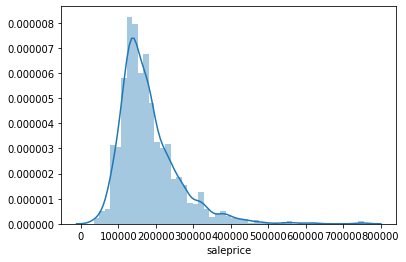

In [8]:
# check how it's distributed.
sns.distplot(house_df["saleprice"])
plt.show()

# Little left leaning so I log it to try to get it normal

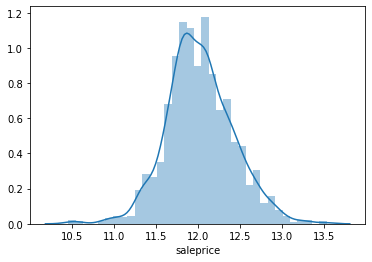

In [9]:
#Log of saleprice
sns.distplot(np.log(house_df["saleprice"]))
plt.show()

# That looks much better. I want to try using that for the saleprice

In [10]:
log_df = house_df.copy()
log_df["log_saleprice"] = np.log(log_df["saleprice"])
log_df = log_df.drop(columns=["saleprice"])

In [11]:
top_n_corrs = top_corrs(house_df, "saleprice")
log_top_n_corrs = top_corrs(log_df, "log_saleprice")

display_side_by_side(top_n_corrs, log_top_n_corrs)

,corr,abs_corr
saleprice,1.000000,1.000000
overallqual,0.790982,0.790982
grlivarea,0.708624,0.708624
garagecars,0.640409,0.640409
garagearea,0.623431,0.623431
totalbsmtsf,0.613581,0.613581
firstflrsf,0.605852,0.605852
fullbath,0.560664,0.560664
totrmsabvgrd,0.533723,0.533723
yearbuilt,0.522897,0.522897


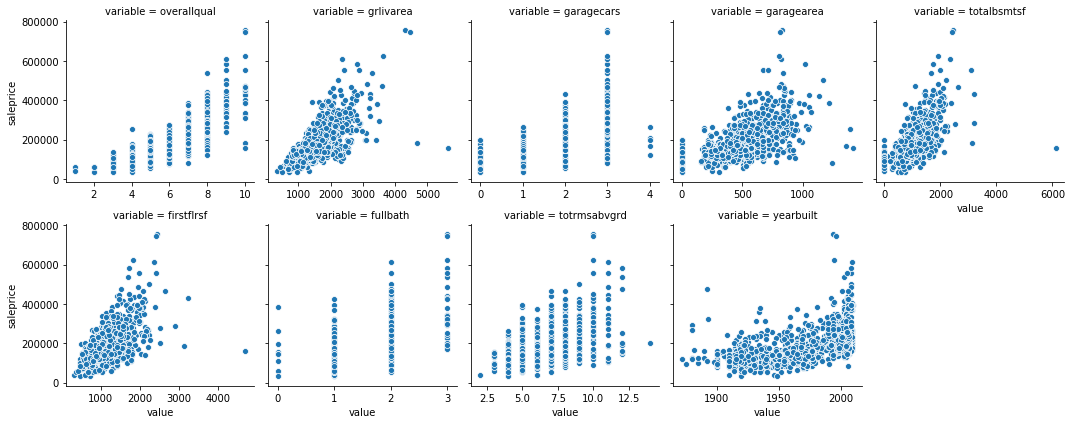

In [12]:
plot_top_corrs(house_df, 'saleprice')

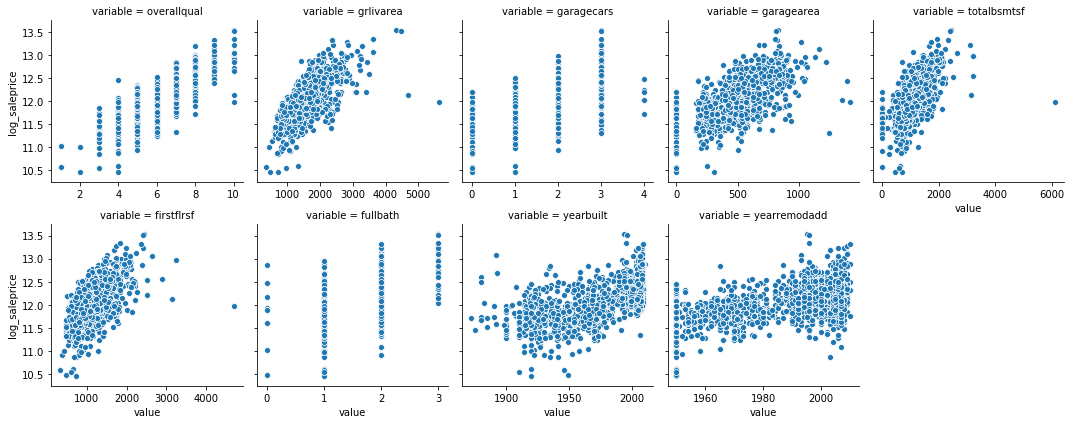

In [13]:
plot_top_corrs(log_df, 'log_saleprice')

# There appears to be a few outliers. I really need to take care of them

In [14]:
drop_ids = log_df.sort_values("firstflrsf", ascending=False).iloc[:4].index
print(f"Dropping house ids {list(drop_ids)}")
log_df = log_df.drop(index=drop_ids)

Dropping house ids [1298, 497, 523, 1024]


In [15]:
drop_ids = log_df.sort_values("totalbsmtsf", ascending=False).iloc[:1].index
display(f"Dropping house ids {list(drop_ids)}")
log_df.iloc[333]['totalbsmtsf']

'Dropping house ids [333]'

3206

In [16]:
log_df = log_df.drop(index=drop_ids)


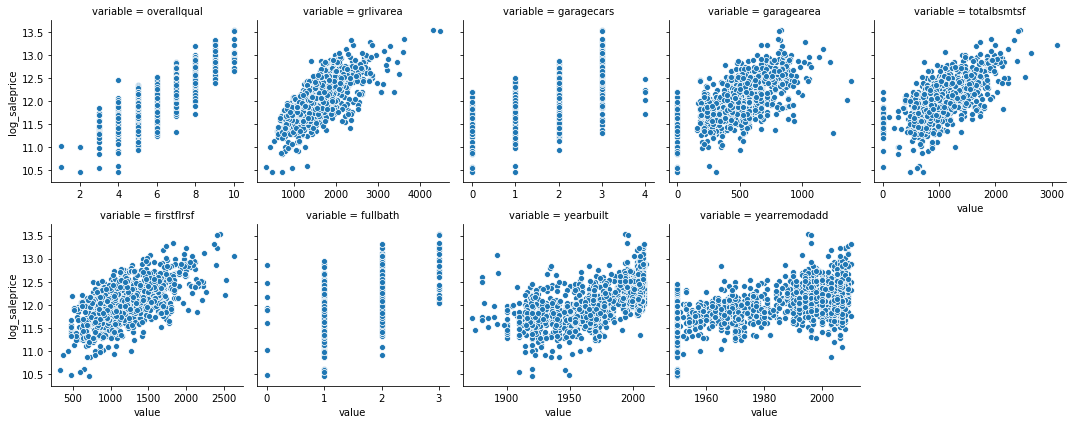

In [17]:
plot_top_corrs(log_df, 'log_saleprice')

# Turning all categorical data to numeric process:
 ### Anova time

In [18]:
cat_cols = log_df.select_dtypes("O").copy()
anova_results = []
for col in cat_cols:
    groups = list(log_df[["log_saleprice", col]].groupby(col))
    samples = [group[1]["log_saleprice"] for group in groups]
    f, p = stats.f_oneway(*samples)

    anova_result = {"col": col, "f": f, "p": p}
    anova_results.append(anova_result)

anova_results_df = pd.DataFrame(anova_results).sort_values("f", ascending=False)
top_f = anova_results_df.head(10)
top_f

,col,f,p
18,exterqual,419.799765,2.760408e-196
30,kitchenqual,396.554749,4.436185e-188
21,bsmtqual,368.997807,5.696455e-177
34,garagefinish,328.320320,3.139450e-117
28,centralair,205.260202,1.203974e-43
20,foundation,126.720907,1.810609e-111
17,masvnrtype,117.431466,4.799295e-68
27,heatingqc,110.935019,1.469701e-82
33,garagetype,100.995009,8.908958e-91
8,neighborhood,78.888638,1.967051e-241


# Now let's check out relationships and strengths of these

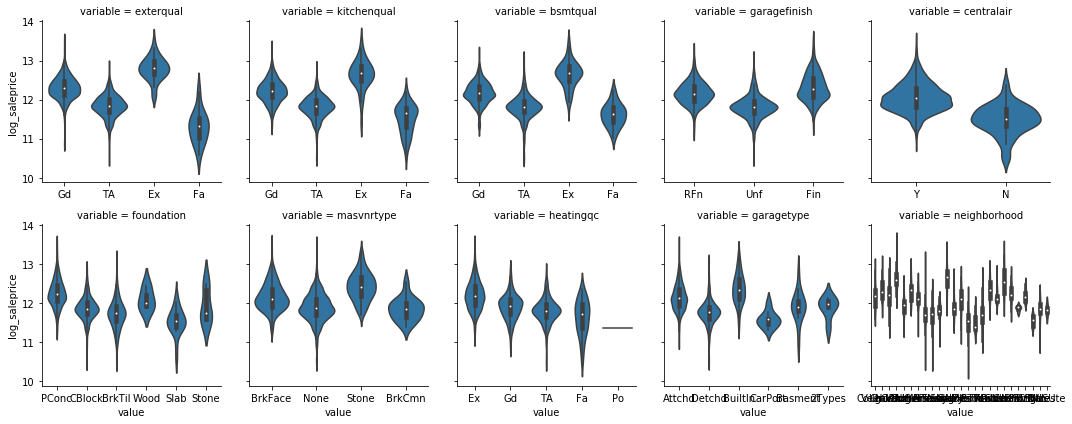

In [19]:
cat_cols = log_df.select_dtypes("O").copy()[top_f["col"]]
cat_cols["log_saleprice"] = log_df["log_saleprice"]

tall_cat_cols = pd.melt(cat_cols, "log_saleprice")

fg = sns.FacetGrid(tall_cat_cols, col="variable", col_wrap=5, sharex=False)
fg.map(sns.violinplot, "value", "log_saleprice")
plt.show()


# Keeping exterqual  and central air. Dropping all else

In [20]:
cat_cols = log_df.select_dtypes("O").copy()
keep_cols = ['exterqual', 'centralair']
drop_cols = [c for c in cat_cols.columns if c not in keep_cols]

log_df = log_df.drop(columns=drop_cols)

In [21]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1459
Data columns (total 40 columns):
id               1455 non-null int64
mssubclass       1455 non-null int64
lotfrontage      1198 non-null float64
lotarea          1455 non-null int64
overallqual      1455 non-null int64
overallcond      1455 non-null int64
yearbuilt        1455 non-null int64
yearremodadd     1455 non-null int64
masvnrarea       1447 non-null float64
exterqual        1455 non-null object
bsmtfinsf1       1455 non-null int64
bsmtfinsf2       1455 non-null int64
bsmtunfsf        1455 non-null int64
totalbsmtsf      1455 non-null int64
centralair       1455 non-null object
firstflrsf       1455 non-null int64
secondflrsf      1455 non-null int64
lowqualfinsf     1455 non-null int64
grlivarea        1455 non-null int64
bsmtfullbath     1455 non-null int64
bsmthalfbath     1455 non-null int64
fullbath         1455 non-null int64
halfbath         1455 non-null int64
bedroomabvgr     1455 non-null int64

# Binary time

In [22]:
log_df["centralair"] = (log_df["centralair"] == "Y").astype(int)

In [23]:
ext_num = {"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
log_df[['exterqual']] = log_df[
    ['exterqual']
].replace(ext_num)

In [24]:
log_df.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,exterqual,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,log_saleprice
0,1,60,65.0,8450,7,5,2003,2003,196.0,3,...,0,61,0,0,0,0,0,2,2008,12.247694
1,2,20,80.0,9600,6,8,1976,1976,0.0,2,...,298,0,0,0,0,0,0,5,2007,12.109011
2,3,60,68.0,11250,7,5,2001,2002,162.0,3,...,0,42,0,0,0,0,0,9,2008,12.317167
3,4,70,60.0,9550,7,5,1915,1970,0.0,2,...,0,35,272,0,0,0,0,2,2006,11.849398
4,5,60,84.0,14260,8,5,2000,2000,350.0,3,...,192,84,0,0,0,0,0,12,2008,12.429216


# FINALLY! TIME TO TRAIN/TEST SPLIT MY DATA! YIPPE!

In [25]:
#There are 0 values. Need to add one to all values so we don't get 0

In [26]:
log_df_copy= log_df.copy()



In [28]:
log_df_copy = log_df.drop(columns = ['lotfrontage', 'garageyrblt'])
log_df_copy = log_df_copy + 1

In [53]:
log_df_copy.isnull().mean()

id               0.0
mssubclass       0.0
lotarea          0.0
overallqual      0.0
overallcond      0.0
yearbuilt        0.0
yearremodadd     0.0
masvnrarea       0.0
exterqual        0.0
bsmtfinsf1       0.0
bsmtfinsf2       0.0
bsmtunfsf        0.0
totalbsmtsf      0.0
centralair       0.0
firstflrsf       0.0
secondflrsf      0.0
lowqualfinsf     0.0
grlivarea        0.0
bsmtfullbath     0.0
bsmthalfbath     0.0
fullbath         0.0
halfbath         0.0
bedroomabvgr     0.0
kitchenabvgr     0.0
totrmsabvgrd     0.0
fireplaces       0.0
garagecars       0.0
garagearea       0.0
wooddecksf       0.0
openporchsf      0.0
enclosedporch    0.0
threessnporch    0.0
screenporch      0.0
poolarea         0.0
miscval          0.0
mosold           0.0
yrsold           0.0
log_saleprice    0.0
dtype: float64

In [33]:
#There's a few infinity values as well
log_df_copy = log_df_copy.fillna(0)

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,exterqual,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,log_saleprice
0,2,61,8451,8,6,2004,2004,197.0,4,707,...,1,62,1,1,1,1,1,3,2009,13.247694
1,3,21,9601,7,9,1977,1977,1.0,3,979,...,299,1,1,1,1,1,1,6,2008,13.109011
2,4,61,11251,8,6,2002,2003,163.0,4,487,...,1,43,1,1,1,1,1,10,2009,13.317167
3,5,71,9551,8,6,1916,1971,1.0,3,217,...,1,36,273,1,1,1,1,3,2007,12.849398
4,6,61,14261,9,6,2001,2001,351.0,4,656,...,193,85,1,1,1,1,1,13,2009,13.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1457,61,7918,7,6,2000,2001,1.0,3,1,...,1,41,1,1,1,1,1,9,2008,13.072541
1456,1458,21,13176,7,7,1979,1989,120.0,3,791,...,350,1,1,1,1,1,1,3,2011,13.254863
1457,1459,71,9043,8,10,1942,2007,1.0,5,276,...,1,61,1,1,1,1,2501,6,2011,13.493130
1458,1460,21,9718,6,7,1951,1997,1.0,3,50,...,367,1,113,1,1,1,1,5,2011,12.864462


In [69]:
X = log_df_copy.drop(columns = 'log_saleprice')
y = log_df_copy['log_saleprice']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69)

In [101]:
#dropping anything with VIF>5
print_vif(log_df_copy.drop(columns=["log_saleprice"]))

VIF results
-------------------------------
const            0.000000
id               1.027278
mssubclass       1.499917
lotarea          1.198561
overallqual      3.639530
overallcond      1.678777
yearbuilt        4.565015
yearremodadd     2.332693
masvnrarea       1.380688
exterqual        2.665268
bsmtfinsf1            inf
bsmtfinsf2            inf
bsmtunfsf             inf
totalbsmtsf           inf
centralair       1.408899
firstflrsf            inf
secondflrsf           inf
lowqualfinsf          inf
grlivarea             inf
bsmtfullbath     2.266755
bsmthalfbath     1.156486
fullbath         2.922553
halfbath         2.170714
bedroomabvgr     2.406566
kitchenabvgr     1.615496
totrmsabvgrd     4.830432
fireplaces       1.594743
garagecars       5.631791
garagearea       5.212999
wooddecksf       1.214772
openporchsf      1.211014
enclosedporch    1.290445
threessnporch    1.024747
screenporch      1.116724
poolarea         1.054557
miscval          1.024328
mosold           1.0

# OLS to see if I can reduce features by comparing dropped vif>5 scores

In [100]:
X_train_const = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_const).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     295.5
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:14:42   Log-Likelihood:                 789.91
No. Observations:                1164   AIC:                            -1508.
Df Residuals:                    1128   BIC:                            -1326.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.8079      1.890      2.543      0.011       1.099       8.517
id            -3.451e-06   8.84e-06     -0.390      0.696   -2.08e-05    1.39e-05
mssubclass       -0.0004      0.000     -4.175      0.000      -0.001      -0.000
lotarea        2.322e-06   3.76e-07      6.182      0.000    1.58e-06    3.06e-06
overallqual       0.0684      0.005     13.580      0.000       0.059       0.078
overallcond       0.0479      0.004     11.131      0.000       0.039       0.056
yearbuilt         0.0027      0.000     10.209      0.000       0.002       0.003
yearremodadd      0.0011      0.000      4.014      0.000       0.001       0.002
masvnrarea    -9.228e-06    2.4e-05     -0.385      0.700   -5.62e-05    3.78e-05
exterqual         0.0385      0.010      3.677      0.000       0.018       0.059
bsmtfinsf1        2.4040      0.945      2.543      0.011       0.549       4.259
bsmtfinsf2        2.4040      0.945      2.543      0.011       0.549       4.259
bsmtunfsf         2.4039      0.945      2.543      0.011       0.549       4.259
totalbsmtsf      -2.4038      0.945     -2.543      0.011      -4.258      -0.549
centralair        0.0653      0.018      3.719      0.000       0.031       0.100
firstflrsf        2.4040      0.945      2.543      0.011       0.549       4.259
secondflrsf       2.4040      0.945      2.543      0.011       0.549       4.259
lowqualfinsf      2.4039      0.945      2.543      0.011       0.549       4.259
grlivarea        -2.4038      0.945     -2.543      0.011      -4.258      -0.549
bsmtfullbath      0.0316      0.011      2.937      0.003       0.010       0.053
bsmthalfbath     -0.0014      0.016     -0.086      0.932      -0.033       0.030
fullbath          0.0083      0.011      0.728      0.467      -0.014       0.031
halfbath          0.0140      0.011      1.264      0.207      -0.008       0.036
bedroomabvgr     -0.0063      0.007     -0.896      0.371      -0.020       0.007
kitchenabvgr     -0.0472      0.021     -2.276      0.023      -0.088      -0.007
totrmsabvgrd      0.0057      0.005      1.133      0.258      -0.004       0.016
fireplaces        0.0298      0.007      4.123      0.000       0.016       0.044
garagecars        0.0394      0.012      3.376      0.001       0.016       0.062
garagearea     6.259e-05   3.93e-05      1.594      0.111   -1.44e-05       0.000
wooddecksf     3.908e-05   3.17e-05      1.231      0.218   -2.32e-05       0.000
openporchsf    3.094e-05   6.18e-05      0.500      0.617   -9.04e-05       0.000
enclosedporch     0.0001   6.81e-05      1.513      0.131   -3.06e-05       0.000
threessnporch     0.0003      0.000      1.975      0.049    1.73e-06       0.001
screenporch       0.0002    6.8e-05      3.513      0.000       0.000       0.000
poolarea       4.423e-05   9.48e-05      0.466   

In [103]:
print_vif(log_df_copy.drop(columns=["log_saleprice", 'garagearea','garagecars', 'firstflrsf','secondflrsf','lowqualfinsf',
'grlivarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf'  ]))

VIF results
-------------------------------
const            2.406370e+06
id               1.018211e+00
mssubclass       1.242261e+00
lotarea          1.166734e+00
overallqual      3.166230e+00
overallcond      1.616857e+00
yearbuilt        3.917472e+00
yearremodadd     2.283010e+00
masvnrarea       1.287744e+00
exterqual        2.611896e+00
centralair       1.395202e+00
bsmtfullbath     1.227199e+00
bsmthalfbath     1.075101e+00
fullbath         2.479961e+00
halfbath         1.423507e+00
bedroomabvgr     2.297505e+00
kitchenabvgr     1.486768e+00
totrmsabvgrd     3.499972e+00
fireplaces       1.449231e+00
wooddecksf       1.189978e+00
openporchsf      1.182684e+00
enclosedporch    1.275451e+00
threessnporch    1.019103e+00
screenporch      1.099166e+00
poolarea         1.036692e+00
miscval          1.018878e+00
mosold           1.045783e+00
yrsold           1.048312e+00
dtype: float64
-------------------------------



In [105]:
log_df = log_df_copy.drop(columns=['garagearea','garagecars', 'firstflrsf','secondflrsf','lowqualfinsf',
'grlivarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf'  ])

In [106]:
DX = log_df.drop(columns = 'log_saleprice')
Dy = log_df_copy['log_saleprice']
DX_train, DX_test, Dy_train, Dy_test = train_test_split(
    DX, Dy, test_size=0.2, random_state=69)

In [107]:
# Keeping all values with 
DX_train_const = sm.add_constant(DX_train)
lm = sm.OLS(Dy_train, DX_train_const).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     251.7
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:28:20   Log-Likelihood:                 571.00
No. Observations:                1164   AIC:                            -1086.
Df Residuals:                    1136   BIC:                            -944.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            19.1339      6.812      2.809      0.005       5.769      32.499
id             3.028e-06   1.06e-05      0.286      0.775   -1.77e-05    2.38e-05
mssubclass       -0.0008      0.000     -6.842      0.000      -0.001      -0.001
lotarea        3.578e-06   4.45e-07      8.035      0.000     2.7e-06    4.45e-06
overallqual       0.1054      0.006     18.592      0.000       0.094       0.117
overallcond       0.0397      0.005      7.807      0.000       0.030       0.050
yearbuilt         0.0023      0.000      8.007      0.000       0.002       0.003
yearremodadd      0.0012      0.000      3.755      0.000       0.001       0.002
masvnrarea        0.0001   2.77e-05      4.419      0.000    6.81e-05       0.000
exterqual         0.0614      0.012      4.935      0.000       0.037       0.086
centralair        0.0872      0.021      4.154      0.000       0.046       0.128
bsmtfullbath      0.1005      0.010     10.450      0.000       0.082       0.119
bsmthalfbath      0.0324      0.019      1.720      0.086      -0.005       0.069
fullbath          0.0682      0.013      5.383      0.000       0.043       0.093
halfbath          0.0360      0.011      3.406      0.001       0.015       0.057
bedroomabvgr     -0.0066      0.008     -0.802      0.423      -0.023       0.010
kitchenabvgr     -0.0134      0.024     -0.562      0.574      -0.060       0.033
totrmsabvgrd      0.0506      0.005      9.953      0.000       0.041       0.061
fireplaces        0.0586      0.008      7.090      0.000       0.042       0.075
wooddecksf        0.0001   3.77e-05      3.542      0.000    5.96e-05       0.000
openporchsf       0.0002   7.34e-05      2.735      0.006    5.67e-05       0.000
enclosedporch     0.0002   8.15e-05      2.205      0.028    1.98e-05       0.000
threessnporch     0.0004      0.000      2.588      0.010       0.000       0.001
screenporch       0.0004   8.09e-05      5.063      0.000       0.000       0.001
poolarea       3.695e-05      0.000      0.326      0.745      -0.000       0.000
miscval       -7.738e-06   8.09e-06     -0.956      0.339   -2.36e-05    8.14e-06
mosold         -9.39e-05      0.002     -0.057      0.955      -0.003       0.003
yrsold           -0.0076      0.003     -2.254      0.024      -0.014      -0.001
==============================================================================
Omnibus:                      151.864   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.787
Skew:                          -0.634   Prob(JB):                    1.62e-107
Kurtosis:                       5.921   Cond. No.                     2.36e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of

# I believe the first model with all the coefficients is better due to higher R and Adjusted R score






# Here are my models. They get their own cell

In [72]:
LRmodel = LinearRegression()
Logmodel = LogisticRegression(solver='lbfgs', max_iter=42069)
Rmodel = Ridge(alpha=50)

# First is Linear, then Log, then Ridge

In [84]:
LRmodel.fit(X_train, y_train)

LRtrain_score = LRmodel.score(X_train, y_train)
LRtest_score = LRmodel.score(X_test, y_test)

print(f"train_score: {LRtrain_score}")
print(f"test_score: {LRtest_score}")



train_score: 0.9016744613312613
test_score: 0.9124639472247488


In [89]:
#Log wont take float values so we gotta convert
LX_train = X_train.astype('int')
LX_test =   X_test.astype('int')
Ly_train = y_train.astype('int')
Ly_test = y_test.astype('int')

In [90]:
Logmodel.fit(LX_train, Ly_train)

Logtrain_score = Logmodel.score(LX_train, Ly_train)
Logtest_score = Logmodel.score(LX_test, Ly_test)

print(f"train_score: {Logtrain_score}")
print(f"test_score: {Logtest_score}")

train_score: 0.9175257731958762
test_score: 0.8831615120274914


In [88]:
Rmodel.fit(X_train, y_train)

y_preds_train = Rmodel.predict(X_train)
y_preds_test = Rmodel.predict(X_test)

print('Train R-squared: {}'.format(Rmodel.score(X_train, y_train)))
print('Test R-squared: {}'.format(Rmodel.score(X_test, y_test)))

Train R-squared: 0.900062491921411
Test R-squared: 0.9116073334468416


# Is that the best Rmodel tho?

In [78]:
alphas = [{'alpha': [1, 5, 10, 100, 500, 1000, 10000]}]

clf = GridSearchCV(Ridge(), param_grid=alphas)
clf.fit(X_train, y_train)

print(clf.best_score_)
print(clf.best_estimator_.alpha)

0.8832016023989715
100


# I guess it's 100. Let's run it again

In [79]:
Rmodel = Ridge(alpha= 100)
Rmodel.fit(X_train, y_train)

y_preds_train = Rmodel.predict(X_train)
y_preds_test = Rmodel.predict(X_test)

print('Train R-squared: {}'.format(Rmodel.score(X_train, y_train)))
print('Test R-squared: {}'.format(Rmodel.score(X_test, y_test)))

Train R-squared: 0.900062491921411
Test R-squared: 0.9116073334468416


In [91]:
print(f"LinearRegression Train R^2: {LRmodel.score(X_train, y_train):.2f}")
print(f"LogRegression Train R^2: {Logmodel.score(LX_train, Ly_train):.2f}")
print(f"LinearRegression Train R^2: {Rmodel.score(X_train, y_train):.2f}")

LinearRegression Train R^2: 0.90
LogRegression Train R^2: 0.92
LinearRegression Train R^2: 0.90


# Best model is Log Regression model with the more coefficients

In [116]:
Ly_pred = Logmodel.predict(LX_test)

cm = confusion_matrix(Ly_test, Ly_pred)
cm_df = pd.DataFrame(
    cm, index=["tru_0", "tru_1", "tru_2", "tru_3"], columns=["pred_0", "pred_1", "pred_2", "pred_3"]
)
# Covnvert to percent of total test set
# cm_df /= y_test.size
display(cm_df)

print(classification_report(Ly_test, Ly_pred))

,pred_0,pred_1,pred_2,pred_3
tru_0,0,2,0,0
tru_1,0,133,10,0
tru_2,0,16,121,1
tru_3,0,0,5,3


              precision    recall  f1-score   support

          11       0.00      0.00      0.00         2
          12       0.88      0.93      0.90       143
          13       0.89      0.88      0.88       138
          14       0.75      0.38      0.50         8

    accuracy                           0.88       291
   macro avg       0.63      0.55      0.57       291
weighted avg       0.88      0.88      0.88       291



# Add National GDP to the year sold value rather than year to see if that has any impact

In [117]:
house_df['yrsold'].unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [128]:
gdp = {2008: 14.72, 2007: 14.48, 2006:13.86, 2009:14.42, 2010:14.96, 2011:15.54}
log_df_gdp = log_df_copy.copy()
log_df_gdp[['yrsold']] = log_df_gdp[['yrsold']].replace(gdp)
type(gdp)

dict

In [129]:
log_df_gdp['yrsold'].unique()

array([14.42, 14.72, 14.48, 14.96, 15.54])

In [130]:
X = log_df_gdp.drop(columns = 'log_saleprice')
y = log_df_gdp['log_saleprice']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69)

In [131]:
X_train_const = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_const).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     295.2
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:56:18   Log-Likelihood:                 789.24
No. Observations:                1164   AIC:                            -1506.
Df Residuals:                    1128   BIC:                            -1324.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.3465      0.195      6.895      0.000       0.963       1.730
id            -3.541e-06   8.85e-06     -0.400      0.689   -2.09e-05    1.38e-05
mssubclass       -0.0004      0.000     -4.121      0.000      -0.001      -0.000
lotarea         2.32e-06   3.76e-07      6.173      0.000    1.58e-06    3.06e-06
overallqual       0.0681      0.005     13.525      0.000       0.058       0.078
overallcond       0.0477      0.004     11.094      0.000       0.039       0.056
yearbuilt         0.0027      0.000     10.248      0.000       0.002       0.003
yearremodadd      0.0011      0.000      3.976      0.000       0.001       0.002
masvnrarea    -9.862e-06    2.4e-05     -0.411      0.681   -5.69e-05    3.72e-05
exterqual         0.0384      0.010      3.665      0.000       0.018       0.059
bsmtfinsf1        0.6733      0.098      6.896      0.000       0.482       0.865
bsmtfinsf2        0.6733      0.098      6.895      0.000       0.482       0.865
bsmtunfsf         0.6732      0.098      6.895      0.000       0.482       0.865
totalbsmtsf      -0.6731      0.098     -6.894      0.000      -0.865      -0.482
centralair        0.0658      0.018      3.745      0.000       0.031       0.100
firstflrsf        0.6733      0.098      6.896      0.000       0.482       0.865
secondflrsf       0.6733      0.098      6.896      0.000       0.482       0.865
lowqualfinsf      0.6732      0.098      6.895      0.000       0.482       0.865
grlivarea        -0.6731      0.098     -6.893      0.000      -0.865      -0.481
bsmtfullbath      0.0310      0.011      2.882      0.004       0.010       0.052
bsmthalfbath     -0.0011      0.016     -0.065      0.948      -0.033       0.031
fullbath          0.0078      0.011      0.682      0.496      -0.015       0.030
halfbath          0.0137      0.011      1.242      0.214      -0.008       0.035
bedroomabvgr     -0.0062      0.007     -0.877      0.380      -0.020       0.008
kitchenabvgr     -0.0478      0.021     -2.302      0.022      -0.088      -0.007
totrmsabvgrd      0.0058      0.005      1.157      0.248      -0.004       0.016
fireplaces        0.0300      0.007      4.150      0.000       0.016       0.044
garagecars        0.0400      0.012      3.430      0.001       0.017       0.063
garagearea     6.116e-05   3.93e-05      1.556      0.120   -1.59e-05       0.000
wooddecksf     3.709e-05   3.17e-05      1.169      0.243   -2.52e-05    9.93e-05
openporchsf    3.346e-05   6.18e-05      0.541      0.588   -8.78e-05       0.000
enclosedporch     0.0001   6.82e-05      1.523      0.128      -3e-05       0.000
threessnporch     0.0003      0.000      1.911      0.056   -6.79e-06       0.001
screenporch       0.0002    6.8e-05      3.456      0.001       0.000       0.000
poolarea       4.869e-05   9.48e-05      0.514   

In [ ]:
#It did nothing...

# Discuss the implications of adding these external variables into your model



# Some of the implications are that the data collection method could influence the results. There is data collection bias as well as inclusion bias. The more external data is added to the model, the more it is being influenced by the one running the model and could be seen as a biased dataset rather than one that will tell the truth. Data can lie and tell whatever story based on what is included and what isn't or even how it is included